### Generate the image captions from the pre-extracted features 

In [1]:
import os
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import numpy as np
import pandas as pd

import random
from tqdm import tqdm

In [2]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D,MaxPool2D
from tensorflow.keras import Input
from tensorflow import io,image
import tensorflow as tf
from PIL import Image

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [4]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


please ensure the kaggle.json ( key file) is avialable in the location

In [33]:
%cd  /content/gdrive/Shareddrives/projects_data/image_caption/

/content/gdrive/Shareddrives/projects_data/image_caption


In [6]:
! pip install -q kaggle

In [ ]:
! kaggle datasets download -d adityajn105/flickr8k

flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! ls

captions.txt
checkpoints
checkpoints-bkup
data
evaluation_metrics.ipynb
feature_extractor_using_CNN_for_captioning.ipynb
flickr8k.zip
image_captioning_from_extracted_feature.ipynb
image_captioning_from_extracted_feature_with_attention.ipynb
image_captioning_without_attention_rnn_decoder.ipynb
Images
load_chk_pnt_evaluation_metrics.ipynb
model_without_attention
modularized
temp


In [8]:
# One of vgg16, InceptionV3, resnet
CNN_model_name='InceptionV3'

In [9]:
image_feature_path= "/content/gdrive/Shareddrives/projects_data/image_caption/data/features/"+CNN_model_name+"/"

### read the files

In [10]:
!unzip \*.zip  && rm *.zip

Archive:  flickr8k.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of *.zip or
        *.zip.zip, and cannot find flickr8k.zip.ZIP, period.

No zipfiles found.


### preview the captions

In [11]:
! head -5 captions.txt

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .


please note same image has multiple captions that collated as list against same image

In [13]:
base_path = os.path.abspath('.')
qual_image_path = base_path+'/'+'Images'

### Read the captions data and process them to generate the test train split

In [14]:
image_captions_df = pd.read_csv("captions.txt",sep=",",header=0)

A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .


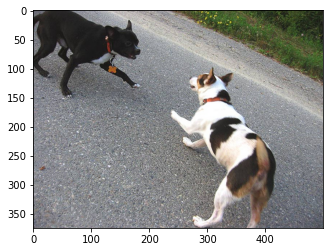

In [15]:
print(image_captions_df['caption'][5])
print(image_captions_df['caption'][6])
plt.imshow(imread(qual_image_path+'/'+image_captions_df['image'][5]))

In [16]:
image_captions_df['image_path'] =  image_feature_path + image_captions_df['image']
image_captions_df['annotation'] = "[start] "+image_captions_df['caption']+" [end]"

In [17]:
image_annotate_agg_df = image_captions_df[['image_path','annotation']].groupby(['image_path'],as_index=False).agg({'annotation':list}).reset_index()

In [18]:
image_annotate_dict={}
for key,val in zip(image_annotate_agg_df['image_path'],image_annotate_agg_df['annotation']):
  image_annotate_dict[key] = val

TODO  : create a function that will generate the dictionary with image as key and caption as list by taking file path containing image and caption as an input

ouput structure:
{'/content/gdrive/MyDrive/Kaggle/Images/1000268201_693b08cb0e.jpg': ['[start]A child in a pink dress is climbing up a set of stairs in an entry way .[end]',
  '[start]A girl going into a wooden building .[end]',
  '[start]A little girl climbing into a wooden playhouse .[end]',
  '[start]A little girl climbing the stairs to her playhouse .[end]',
  '[start]A little girl in a pink dress going into a wooden cabin .[end]'],
 '/content/gdrive/MyDrive/Kaggle/Images/1001773457_577c3a7d70.jpg': ['[start]A black dog and a spotted dog are fighting[end]',
  '[start]A black dog and a tri-colored dog playing with each other on the road .[end]',
  '[start]A black dog and a white dog with brown spots are staring at each other in the street .[end]',
  '[start]Two dogs of different breeds looking at each other on the road .[end]',
  '[start]Two dogs on pavement moving toward each other .[end]'] }

### Create train test validation split on the dataset with shuffle

train_test_val_split(image_caption_dict , split_fraction=,shuffle=False)
returns train_image, train_annotation ,test_image,test_annotation , val_image,val_annotation

In [19]:
def train_test_split(annotate_dict,split_fraction=.2,shuffle=False):
  image_path = list(annotate_dict.keys())
  if shuffle:
    random.shuffle(image_path)

  l = len(image_path)
  train_idx = int(l * (1-split_fraction))
  
  train_img_path = image_path[:train_idx]
  test_img_path = image_path[train_idx:]

  train_annotate_dict = { k : annotate_dict[k] for k in train_img_path }
  test_annotate_dict = { k : annotate_dict[k] for k in test_img_path }
  
  return train_annotate_dict,test_annotate_dict
  



In [20]:
def explode_dict_to_list(annotate_dict):
  
  key_list =[]
  value_list =[]
  
  for k,v in annotate_dict.items():
    for val in v:
      key_list.append(k)
      value_list.append(val) 
      
  return key_list, value_list



In [21]:
train_dict,test_dict = train_test_split(image_annotate_dict,0.15)

In [ ]:
print("Total::",len(image_annotate_dict.keys()))
print("Train::",len(train_dict.keys()))
print("Test::",len(test_dict.keys()))

Total:: 8091
Train:: 6877
Test:: 1214


In [23]:
train_dict,val_dict = train_test_split(train_dict,0.15)

In [34]:
print("Train::",len(train_dict.keys()))
print("Val::",len(val_dict.keys()))

Train:: 4968
Val:: 877


In [25]:
train_image_path , train_captions = explode_dict_to_list(train_dict) 
test_image_path , test_captions = explode_dict_to_list(test_dict) 
valid_image_path , valid_captions = explode_dict_to_list(val_dict) 

In [35]:
print(len(train_image_path) , len(train_captions))

24840 24840


In [ ]:
# print(train_captions[10])
# print(train_captions[11])
# plt.imshow(imread(qual_image_path+'/'+train_image_path[11]))

### Load the pre trained model for feature extraction in CNN

### Pre process the text caption to remove any stop words simillar to standardization and tokenise them as done in the assignement. The function pre process caption need to access the list of 


In [36]:
def standardize(inputtext):
  lower = tf.strings.lower(inputtext)
  final_text = tf.strings.regex_replace(lower,
                                  r"""[.,.,#,$,!,\\,",\*,(,),\/,:,;,=,+,?,^,<,>,_,`,\-,%,&,@,|,{,},~]""", "") # Excluding '[', ']' as they are part of masks
  
  final_text = tf.strings.regex_replace(final_text,r"\s[b-z]{1}\s", "") #  removing one letter words 

  final_text = tf.strings.regex_replace(final_text,r"[a-z]*[0-9]+[a-z]*", "")

  return final_text
  

max_length =17 
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
      max_tokens=vocabulary_size,
      standardize=standardize,
      output_sequence_length=max_length)

tokenizer.adapt(train_captions)


In [37]:
standardize('a sample text to check ..# qtet678 g j')

<tf.Tensor: shape=(), dtype=string, numpy=b'a sample text to check  '>

In [38]:
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)


### Translate them to image feature and vectorized text captions using map function 

In [39]:
print(image_feature_path)

/content/gdrive/Shareddrives/projects_data/image_caption/data/features/InceptionV3/


In [40]:
BATCH_SIZE = 128
def gen_data(image_nm, caption):
    # print(image_nm)
    # feature_vector = np.load(str(image_nm).replace('[',"").replace(']',"")+'.npy')
    feature_vector = np.load(image_nm.decode("utf-8")+'.npy')
    # print(feature_vector)
    caption_vector = tokenizer(caption)
    return feature_vector,caption_vector

def make_dataset(image_path, caption_text):    
    dataset = tf.data.Dataset.from_tensor_slices((image_path, caption_text))
    dataset = dataset.map(lambda img_file_nm,caption : tf.numpy_function(gen_data,[img_file_nm,caption],[tf.float32, tf.int64]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset.shuffle(2048,seed=random.seed(42)).batch(BATCH_SIZE).prefetch(16).cache() # in-memory caching to speed up preprocessing.



#### test the gen data function to see if it loads image features sfrom numpy and vectorizes the captions

units represents the hidden unit dimension

In [41]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(train_image_path) // BATCH_SIZE

attention_features_shape = 64

In [42]:
train_ds =  make_dataset(train_image_path , train_captions)
valid_ds = make_dataset(valid_image_path , valid_captions)
test_ds = make_dataset(test_image_path , test_captions)

**From here use for the subsequent model definition and run**


In [43]:
# for tst_feat_vec , tst_cap_vec in test_ds.take(1):
#   print(tst_feat_vec )
#   print(tst_cap_vec )

In [44]:
if CNN_model_name=='vgg16':
  features_shape = 512
elif CNN_model_name=='InceptionV3':
  features_shape = 2048
elif CNN_model_name=='resnet':
  features_shape = 2048

#### Modelling Process

It involves following components:

1) Encoder (Image feature) :  As the feature has been extracted from the image using pre-trained model , full connected network with embedding dimension is used to preseve  spatial information 

2) Decoder  : Recurrent network using LSTM or GRU that makes use of vectorized captions 

i) Attention : As decoder generates each word  in the output , this module generates context vector to focus on most relevent part of image for generating that word

ii) Sequence Generator : Linear layers that takes decoder output and produces a probability for each word from vocabulary for each position in the predicted sequence

### Defining CNN encoder 

In [45]:
class CNN_Encoder(tf.keras.Model):
    
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 7*7 or 8*8, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### RNN decoder implements GRU with additive attention mechanism to generate the sequence
1) features :  CNN encoder output representing the decoder output 

2) hidden : initialized to 0 representing the hidden state of RNN

3) x  : tokenised caption input to the decoder

It uses attention mechanism to align the relevent part of feature to predict the next sequence

Attention function:

e(i,j) = f(s(t-1) , h(j))

e(i,j) = Vattn(T) * tanh(Uattn * h(j) + Wattn * s(t) )

attention_weights(alpha(ij)) = softmax(e(ij)

Context vector or C(t) = sum(j over 1 to T)(attention_weights * features )


In [46]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    # attention mechanism
    self.Uattn = layers.Dense(units)
    self.Wattn = layers.Dense(units)
    self.Vattn = layers.Dense(1)

  def call(self, x, features, hidden):

    # feature shape ==> (batch, 7*7 /8*8 , 256)
    # hidden shape ==> (batch , hidden_size/units ) => (batch, 512)
    # hidden with time axis shape = = (batch , 1,hidden_size / units)=> (batch, 512)

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    #attention score shape = (batch size, 7 * 7 / 8 * 8,1) i.e score for each pixel from encoder
    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

    # self.Uattn(features) => (batch , 7 * 7/8 * 8, units)
    # self.Wattn((hidden state with time axis)) =>  (batch , 1,512)
    # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) => (batch,49,512)
    # attention score self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) => (batch,49,1) 

    # defining attention weights
    
    attention_weights = tf.nn.softmax(score,axis=1)
    # attention weight shape ==> (batch, 7*7 /8*8 , 1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector,axis=1)

    # context_vector (batch,embed dim) = attentionWeight(batch,,7*7 /8*8 ,1) * features(batch, 7*7 /8*8,embed dim )
    # after sum over time = > (batch,embed_dim )
    
    x = self.embedding(x)
    # x shape after passing through embedding == (batch, 1, embedding_dim)

    
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length:17, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length:17, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length:17, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [47]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [48]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [49]:
checkpoint_path = "/checkpoints/"+CNN_model_name+"/"+"train/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [50]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

Teacher forcing method is used during training where in, ground truth captions of previous timestep are used to generate/predicte the word : instead of predicted word from previous timestep (that could be errorneous)

In [51]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [52]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('[start]')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [53]:
import time

In [54]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_ds):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 5.9026
Epoch 1 Batch 100 Loss 3.5836
Epoch 1 Loss 3.661366
Time taken for 1 epoch 2190.83 sec

Epoch 2 Batch 0 Loss 3.6839
Epoch 2 Batch 100 Loss 3.5259
Epoch 2 Loss 3.447246
Time taken for 1 epoch 16.67 sec

Epoch 3 Batch 0 Loss 3.1189
Epoch 3 Batch 100 Loss 2.5922
Epoch 3 Loss 2.730710
Time taken for 1 epoch 16.58 sec

Epoch 4 Batch 0 Loss 2.6518
Epoch 4 Batch 100 Loss 2.3347
Epoch 4 Loss 2.449814
Time taken for 1 epoch 16.59 sec

Epoch 5 Batch 0 Loss 2.4433
Epoch 5 Batch 100 Loss 2.2045
Epoch 5 Loss 2.314787
Time taken for 1 epoch 16.62 sec

Epoch 6 Batch 0 Loss 2.3212
Epoch 6 Batch 100 Loss 2.1298
Epoch 6 Loss 2.226784
Time taken for 1 epoch 16.73 sec

Epoch 7 Batch 0 Loss 2.2439
Epoch 7 Batch 100 Loss 2.0650
Epoch 7 Loss 2.155925
Time taken for 1 epoch 16.56 sec

Epoch 8 Batch 0 Loss 2.1852
Epoch 8 Batch 100 Loss 2.0051
Epoch 8 Loss 2.098150
Time taken for 1 epoch 16.57 sec

Epoch 9 Batch 0 Loss 2.1228
Epoch 9 Batch 100 Loss 1.9648
Epoch 9 Loss 2.054771
Time t

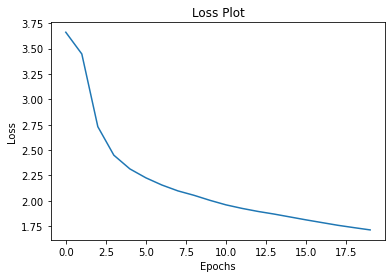

In [55]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

During inference , feature extract of test image is used generate the caption . The greedy search method is used to predict the output by pikcing word with highest probability at each timestep and this is fed back to the decoder during next timestap

In [97]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    
    img_tensor_val = np.load(image+'.npy')


    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('[start]')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        # attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '[end]':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    # attention_plot = attention_plot[:len(result), :]
    return result, None

In [98]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [58]:
%cd  /content/gdrive/Shareddrives/projects_data/image_caption/

/content/gdrive/Shareddrives/projects_data/image_caption


In [92]:
def cleanup_text(caption):

  excl_list = ['[start]' , '[end]']
  for sub in excl_list:

    caption = caption.replace( sub , ' ')

  return caption


/content/gdrive/Shareddrives/projects_data/image_caption/data/features/InceptionV3/3454988449_1de1ef4f20.jpg
Real Caption: ['Two girls playing at a playground .', 'Two girls playing on parallel bars at the playground .', 'Two girls play on a set of parallel bars .', 'Two little girls playing on the parallel bars .', 'Two young girls play on a set of parallel bars in a playground .']
Prediction Caption: a woman in a purple top poses another player shooting action  


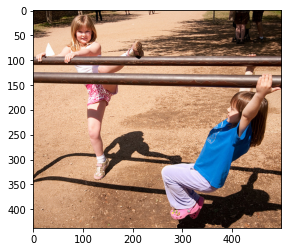

In [101]:
# captions on the validation set
rid = np.random.randint(0, len(valid_image_path))
# rid=3761
image = valid_image_path[rid]
#get the indices of matching path to get all the real captions
captions_list = []
image_indices= [ i for i,imgname in enumerate(valid_image_path) if imgname==image]
for i in image_indices:
  real_caption = cleanup_text(valid_captions[i])
  captions_list.append(real_caption.strip())


print(image)
# real_caption = valid_captions[rid]
result, attention_plot = evaluate(image)

print('Real Caption:', captions_list)
print('Prediction Caption:', cleanup_text(' '.join(result)) )
plt.imshow(imread('Images'+'/'+image.split('/')[-1] ) )
# plot_attention(image, result, attention_plot)

### Evaluation of metrics

In [102]:
corpus_references = []
corpus_predictions = []
processed = set()

for rid in range(0, len(valid_image_path)):
  print(rid)
  image = valid_image_path[rid]
  if image not in processed:
    processed.add(image)
    #print(image)
    captions_list = []
    image_indices= [ i for i,imgname in enumerate(valid_image_path) if imgname==image]
    for i in image_indices:
      real_caption = cleanup_text(valid_captions[i])
      captions_list.append(real_caption.strip())
    
    try:
      result, attention_plot = evaluate(image)
      #print('Real Caption:', captions_list)
      #print('Prediction Caption:', ' '.join(result))
      corpus_references.append(captions_list)
      corpus_predictions.append(cleanup_text(' '.join(result)))
    except:
      print("An exception occurred")

# print(len(corpus_predictions))
# print(len(corpus_references))
# print(corpus_predictions[10])
# print(corpus_references[10])

### language evaluation metrics

In [62]:
! pip install rouge_score
! pip install evaluate
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 101 kB 8.0 MB/s 
     |████████████████████████████████| 140 kB 61.1 MB/s 
     |████████████████████████████████| 212 kB 97.8 MB/s 
     |████████████████████████████████| 362 kB 82.6 MB/s 
     |████████████████████████████████| 1.1 MB 66.2 MB/s 
     |████████████████████████████████| 596 kB 72.6 MB/s 
     |████████████████████████████████| 127 kB 61.3 MB/s 
     |████████████████████████████████| 144 kB 93.7 MB/s 
     |████████████████████████████████| 271 kB 96.6 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempti

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 7.3 MB/s 


In [63]:
import evaluate
from torchmetrics.functional.text.rouge import rouge_score
import nltk
nltk.download("popular")
from nltk.translate.meteor_score import meteor_score
import numpy as np

from pprint import pprint

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [64]:
def corpus_bleu(corpus_predictions, corpus_references):
    '''
        corpus_predictions: list of prediction strings
        corpus_references: list of list reference strings
    '''

    bleu = evaluate.load("bleu")
    results = bleu.compute(predictions=corpus_predictions, references=corpus_references)

    return results

# METEOR
def corpus_meteor(corpus_predictions, corpus_references):
    '''
        corpus_predictions: list of prediction strings
        corpus_references: list of list reference strings
    '''

    corpus_meteor_score = []
    for (references, prediction) in zip(corpus_references, corpus_predictions):
        references = [nltk.word_tokenize(reference) for reference in references]
        prediction = nltk.word_tokenize(prediction)
        corpus_meteor_score.append(meteor_score(references, prediction))

    corpus_meteor_score = np.mean(np.array(corpus_meteor_score))
    return corpus_meteor_score

# ROUGE
def corpus_rouge(corpus_predictions, corpus_references):
    '''
        corpus_predictions: list of prediction strings
        corpus_references: list of list reference strings
    '''

    results = rouge_score(corpus_predictions, corpus_references)
    return results

In [65]:
bleu_results = corpus_bleu(corpus_predictions, corpus_references)
meteor_results = corpus_meteor(corpus_predictions, corpus_references)
rouge_results = corpus_rouge(corpus_predictions, corpus_references)

print("\nCorpus Metrics")
print("===================================================\n")
print(f"BLEU-4 Score: {bleu_results['bleu']:.2%}")
print(f"METEOR Score: {meteor_results:.2%}")
print(f"ROUGE-L Score: {rouge_results['rougeL_fmeasure']:.2%}")

print("\nBLEU")
print("===================================================\n")
pprint(bleu_results)

print("\nMETEOR")
print("===================================================\n")
pprint(meteor_results)

print("\nROUGE")
print("===================================================\n")
pprint(rouge_results)


Corpus Metrics

BLEU-4 Score: 1.65%
METEOR Score: 15.85%
ROUGE-L Score: 22.44%

BLEU

{'bleu': 0.0165189324010487,
 'brevity_penalty': 1.0,
 'length_ratio': 1.2551094361501667,
 'precisions': [0.2986488047118605,
                0.05191467489077358,
                0.00724112961622013,
                0.000663239927043608],
 'reference_length': 6899,
 'translation_length': 8659}

METEOR

0.1584925407815848

ROUGE

{'rouge1_fmeasure': tensor(0.2526),
 'rouge1_precision': tensor(0.2844),
 'rouge1_recall': tensor(0.2530),
 'rouge2_fmeasure': tensor(0.0413),
 'rouge2_precision': tensor(0.0475),
 'rouge2_recall': tensor(0.0422),
 'rougeL_fmeasure': tensor(0.2244),
 'rougeL_precision': tensor(0.2546),
 'rougeL_recall': tensor(0.2236),
 'rougeLsum_fmeasure': tensor(0.2244),
 'rougeLsum_precision': tensor(0.2546),
 'rougeLsum_recall': tensor(0.2236)}
